In [13]:
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score
from tqdm.auto import tqdm

SEED = 42
random.seed(SEED)

In [14]:
chromosome_types = {
    'n_estimators': int,        # Number of trees (5 to 200)
    'max_depth': int,           # Max depth (10 to 100)
    'min_samples_split': int,   # Minimum samples to split (2 to 10)
    'min_samples_leaf': int,    # Minimum samples per leaf (1 to 10)
    'criterion': bool           # Criterion: 0:'gini' or 1:'entropy'
}

### Fitness function

In [15]:
def evaluate_fitness(chromosome, X_train, y_train, X_val, y_val):
    # Create and train the model
    model = RandomForestClassifier(**chromosome, random_state=SEED)
    model.fit(X_train, y_train)
    
    # Evaluate the model on the validation set
    predictions = model.predict(X_val)
    
    # Return the f1 score
    return balanced_accuracy_score(y_val, predictions)

We additionally define an "interface" for the evaluation of the fitness of each individual in the population. This function will be useful to parallelize the evaluation of the fitness of each individual in the population.

In [16]:
# Serial implementation
def evalutate_multiple_fitness(chromosomes, X_train, y_train, X_val, y_val):
    return [evaluate_fitness(chromosome, X_train, y_train, X_val, y_val) for chromosome in chromosomes]


# Parallel implementation
from joblib import Parallel, delayed

def evalutate_multiple_fitness_parallel(chromosomes, X_train, y_train, X_val, y_val):
    return Parallel(n_jobs=5)(delayed(evaluate_fitness)(chromosome, X_train, y_train, X_val, y_val) for chromosome in chromosomes)

### Population initialization

In [17]:
def initialize_population(pop_size):
    population = []
    for _ in range(pop_size):
        chromosome = {
            'n_estimators': random.randint(5, 200),
            'max_depth': random.randint(10, 100),
            'min_samples_split': random.randint(2, 10),
            'min_samples_leaf': random.randint(1, 10),
            'criterion': random.choice(["gini", "entropy"])
        }
        population.append(chromosome)
    return population

### Mutation operator

- For binary variables we just flip the bit with a probability $\tilde{p} = 1/n$ where $n$ is the size of the population.
- For positive integer variables we add a random number between $-1$ and $1$ to the variable.
- For real variables we add a random noise from a gaussian distribution with mean $0$ and standard deviation $0.1$.

In [18]:
def mutate(chromosome):
    for gene in chromosome:
        gene_type = chromosome_types.get(gene, None)
        if gene_type == bool:
            chromosome[gene] = "gini" if chromosome[gene] == "entropy" else "entropy"
        elif gene_type == int:
            noise = random.randint(-2, 2)
            chromosome[gene] = max(1, min(chromosome[gene] + noise, 200)) # boundary conditions: 
        elif gene_type == float:
            noise = random.normalvariate(0, 0.1)
            chromosome[gene] += noise
        else:
            raise ValueError(f"Unknown gene type")

### Crossover operator

In [19]:
def crossover(chromosome1, chromosome2):
    child = {}
    for gene in chromosome1:
        child[gene] = random.choice([chromosome1[gene], chromosome2[gene]])
    return child

### Selection operator

In [20]:
def select(population, X_train, y_train, X_val, y_val, tournament_size):
    # Tournament selection
    selected = []
    for _ in range(len(population)):
        tournament = random.sample(population, tournament_size)
        winner = max(tournament, key=lambda c: evaluate_fitness(c, X_train, y_train, X_val, y_val))
        selected.append(winner)
    return selected

### Termination condition

In [21]:
def termination_condition(best_fitness, max_generations):
    return best_fitness == 1.0 or max_generations == 0

### Genetic algorithm

In [22]:
def genetic_algorithm(X_train, y_train, X_val, y_val, pop_size=100, max_generations=100, tournament_size=3, mutation_rate=0.1):
    # Initialize the population
    population = initialize_population(pop_size)
    
    # Create "history" lists to track the evolution of the best chromosome
    population_history = [population]
    fitness_history = []
    
    # Evolution loop
    best_chromosome = None
    best_fitness = 0
    for generation in tqdm(range(max_generations)):
        # Evaluate the population
        fitness = evalutate_multiple_fitness_parallel(population, X_train, y_train, X_val, y_val)
        fitness_history.append(fitness)
        
        # Select the best chromosome
        best_idx = fitness.index(max(fitness))
        if fitness[best_idx] > best_fitness:
            best_fitness = fitness[best_idx]
            best_chromosome = population[best_idx]
        
        # Termination condition
        if termination_condition(best_fitness, max_generations - generation):
            break
        
        # Select the next generation
        selected = select(population, X_train, y_train, X_val, y_val, tournament_size)
        
        # Crossover
        children = []
        for _ in range(pop_size // 2):
            parent1 = random.choice(selected)
            parent2 = random.choice(selected)
            child1 = crossover(parent1, parent2)
            child2 = crossover(parent1, parent2)
            children.extend([child1, child2])
        
        # Mutation
        for child in children:
            if random.random() < mutation_rate:
                mutate(child, pop_size)
        
        # Store the current population and move to the next generation
        population_history.append(population)
        population = children
    
    return best_chromosome, best_fitness, {'population': population_history, 'fitness': fitness_history}

## Experiment

### Data loading

In [23]:
import pandas as pd

# Load the dataset
df = pd.read_parquet('datasets/creditcard_downsampled.parquet')
df_train, df_val = train_test_split(df, test_size=0.2, random_state=SEED)

# Split the data into features and target
X_train, y_train = df_train.drop(columns=['Class']), df_train['Class']
X_val, y_val = df_val.drop(columns=['Class']), df_val['Class']

# Standardize the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

In [24]:
# Run the genetic algorithm
best_chromosome, best_fitness, history = genetic_algorithm(
    X_train,
    y_train,
    X_val,
    y_val,
    pop_size=5,
    max_generations=10,
    tournament_size=3,
    mutation_rate=0.2
)

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
best_fitness_history = [max(fitness) for fitness in history['fitness']]

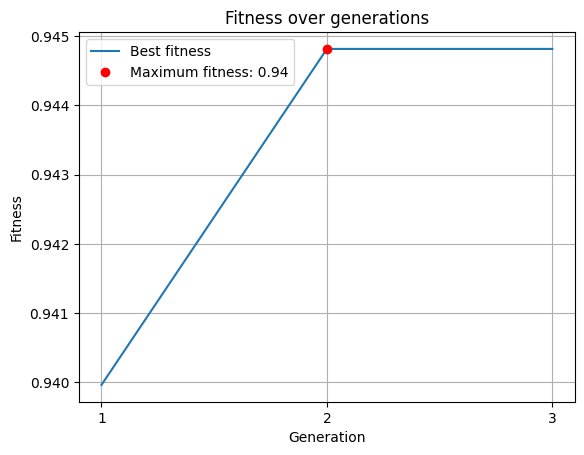

In [30]:
import matplotlib.pyplot as plt

y_max = max(best_fitness_history)
x_max = best_fitness_history.index(y_max) + 1

x_generations = list(range(1,1+len(best_fitness_history)))
fig, ax = plt.subplots()
# Plot fitness over generations
ax.plot(x_generations, best_fitness_history, label='Best fitness')
# Highlight the maximum fitness
ax.plot(x_max, y_max, 'ro', label=f'Maximum fitness: {y_max:.2f}')
ax.xaxis.set_major_locator(plt.MaxNLocator(integer=True))
ax.set_xlabel('Generation')
ax.set_ylabel('Fitness')
ax.legend()
ax.grid(True)
ax.set_title('Fitness over generations')
plt.show()